# DATA PREPROCESSING

In [62]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

In [63]:
export = pd.read_csv("export.csv")

In [8]:
export['new_session'] = export['account_id'].ne(export['account_id'].shift()).cumsum()

In [9]:
mask_data = export[['ed_id', 'new_session']]

In [10]:
def process_journey_to_mask(group):
    """
    Creates a mask for each journey according to the specified criteria:
    - If ed_id = 29 is present, the mask includes rows up to and including the first occurrence of ed_id = 29.
    - If ed_id = 29 is not present, the mask includes all rows.
    
    Returns a boolean mask that can be applied to a DataFrame.
    """
    # Initialize a mask with all False
    mask = pd.Series(False, index=group.index)
    
    if 29 in group['ed_id'].values:
        # Find the index of the first occurrence of ed_id = 29
        first_occurrence_index = group[group['ed_id'] == 29].index[0]
        # Update the mask to True for all rows up to and including the first occurrence of ed_id = 29
        mask.loc[:first_occurrence_index] = True
    else:
        # If ed_id = 29 is not present, all rows are included
        mask[:] = True
    
    return mask

In [11]:
processed_journeys_by_session = [process_journey_to_mask(group) for _, group in mask_data.groupby('new_session')]

In [12]:
activation_mask = pd.concat(processed_journeys_by_session)

In [13]:
up_to_activation = export[activation_mask]

In [19]:
grouped_lists = up_to_activation.groupby('new_session')['ed_id'].apply(list).reset_index()

In [21]:
grouped_lists.to_csv('GroupedLists.csv', index = False)

In [14]:
up_to_act = up_to_activation[["new_session","ed_id"]].copy()
# select customer/account/ed_id, count each observation
up_to_act["count"] = up_to_act.groupby(by = ["new_session","ed_id"])["ed_id"].transform("count")
# groups are duplicated, so remove duplicates
up_to_act = up_to_act.drop_duplicates()

In [15]:
up_to_act = up_to_act.pivot(index = ["new_session"], columns="ed_id", values="count").fillna(0)

In [16]:
up_to_act['activated'] = [1 if item == 1 else 0 for item in up_to_act[29]]

In [18]:
up_to_act.to_csv('ActivationLogRegdata.csv', index = False)

# LOGISTIC REGRESSION

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [6]:
up_to_act = pd.read_csv('ActivationLogRegdata.csv')

In [7]:
up_to_act.head(5)

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,27,28,29,activated
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,5.0,1.0,1.0,66.0,6.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
X = up_to_act.drop(columns = ['29', 'activated'])
Y = up_to_act[['activated']].values.flatten()

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
model = LogisticRegression()
model.fit(X_train, Y_train)

/Users/jessiebaker/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [11]:
# Make predictions
Y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.8660363988316424


# DECISION TREE

## Frequency

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [13]:
X = up_to_act.drop(columns = ['29', 'activated'])
Y = up_to_act[['activated']].values.flatten()

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [15]:
clf = DecisionTreeClassifier(random_state=42)

In [16]:
clf.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

   Feature  Importance
6        7      2.6797
11      12      1.3928
3        4      1.0749
4        5      0.8196
18      19      0.5700
10      11      0.5506
14      15      0.5398
0        1      0.5007
5        6      0.4374
20      21      0.3890
23      24      0.3241
1        2      0.2193
2        3      0.1915
17      18      0.0778
21      22      0.0745
7        8      0.0708
12      13      0.0298
25      28      0.0292
22      23      0.0247
13      14      0.0017
19      20      0.0011
15      16      0.0008
9       10      0.0002
24      27      0.0000
8        9      0.0000
16      17      0.0000


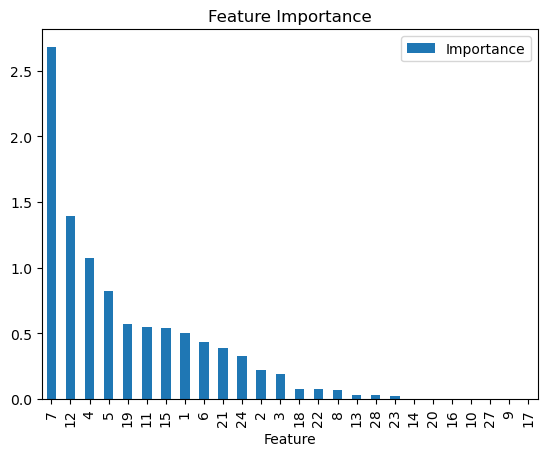

In [17]:
pd.set_option('display.float_format', '{:.4f}'.format)

# Extracting feature importance
feature_importance = clf.feature_importances_ * 10

# Creating a DataFrame for better visualization
features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sorting the DataFrame by importance in descending order
features = features.sort_values(by='Importance', ascending=False)

# Displaying feature importance
print(features)

# Optionally, you can also plot the feature importances
features.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance')
plt.show()

In [20]:
y_pred_clf = clf.predict(X_test)
accuracy_clf = accuracy_score(Y_test, y_pred_clf)
precision_clf = precision_score(Y_test, y_pred_clf)
recall_clf = recall_score(Y_test, y_pred_clf)

print(f"Precision: {precision_clf:.4f}")
print(f"Recall: {recall_clf:.4f}")
print(f'Accuracy: {accuracy_clf:.4f}')

Precision: 0.6887
Recall: 0.6007
Accuracy: 0.8390


## Existence

In [21]:
existence = up_to_act.applymap(lambda x: 1 if x > 1 else x)

In [22]:
X = existence.drop(columns = ['29', 'activated'])
Y = existence[['activated']].values.flatten()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
clf_existence = DecisionTreeClassifier(random_state=42)

In [24]:
clf_existence.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

   Feature  Importance
6        7      4.8653
11      12      2.4941
14      15      0.9799
20      21      0.4574
4        5      0.4249
7        8      0.1299
0        1      0.1255
17      18      0.1098
18      19      0.0997
5        6      0.0660
10      11      0.0459
25      28      0.0408
21      22      0.0307
3        4      0.0305
23      24      0.0286
2        3      0.0267
1        2      0.0151
12      13      0.0125
22      23      0.0106
13      14      0.0035
15      16      0.0013
19      20      0.0009
9       10      0.0005
24      27      0.0001
8        9      0.0000
16      17      0.0000


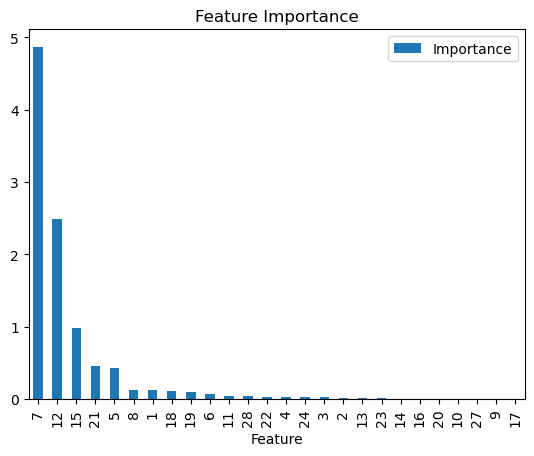

In [25]:
# Extracting feature importance
feature_importance = clf_existence.feature_importances_ * 10

# Creating a DataFrame for better visualization
features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sorting the DataFrame by importance in descending order
features = features.sort_values(by='Importance', ascending=False)

# Displaying feature importance
print(features)

# Optionally, you can also plot the feature importances
features.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance')
plt.show()

In [26]:
y_pred_clf_existence = clf_existence.predict(X_test)
accuracy_clf_existence = accuracy_score(Y_test, y_pred_clf_existence)
precision_clf_existence = precision_score(Y_test, y_pred_clf_existence)
recall_clf_existence = recall_score(Y_test, y_pred_clf_existence)

print(f'Precision: {precision_clf_existence:.4f}')
print(f'Recall: {recall_clf_existence:.4f}')
print(f'Accuracy: {accuracy_clf_existence:.4f}')

Precision: 0.9400
Recall: 0.4908
Accuracy: 0.8703


# RANDOM FOREST

## Frequency

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [28]:
def custom_score(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    # Here you can combine recall and precision in a way that suits your needs
    return (recall + precision) / 2  # As an example, averaging recall and precision

custom_scorer = make_scorer(custom_score)

In [29]:
X = up_to_act.drop(columns = ['29', 'activated'])
Y = up_to_act['activated'].values.flatten()

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [32]:
rf_clf = RandomForestClassifier(random_state = 42) 

In [33]:
rf_clf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [34]:
y_pred_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(Y_test, y_pred_rf)
precision_rf = precision_score(Y_test, y_pred_rf)
recall_rf = recall_score(Y_test, y_pred_rf)

print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f'Accuracy: {accuracy_rf:.4f}')

Precision: 0.8298
Recall: 0.5695
Accuracy: 0.8687


   Feature  Importance
6        7      1.2423
3        4      1.2233
7        8      1.1323
11      12      1.1257
0        1      0.8889
4        5      0.7025
18      19      0.6927
10      11      0.5757
5        6      0.5579
20      21      0.5522
23      24      0.3374
14      15      0.2832
2        3      0.2433
1        2      0.2100
17      18      0.0993
21      22      0.0532
12      13      0.0293
25      28      0.0260
22      23      0.0208
13      14      0.0015
15      16      0.0013
19      20      0.0010
9       10      0.0002
24      27      0.0000
8        9      0.0000
16      17      0.0000


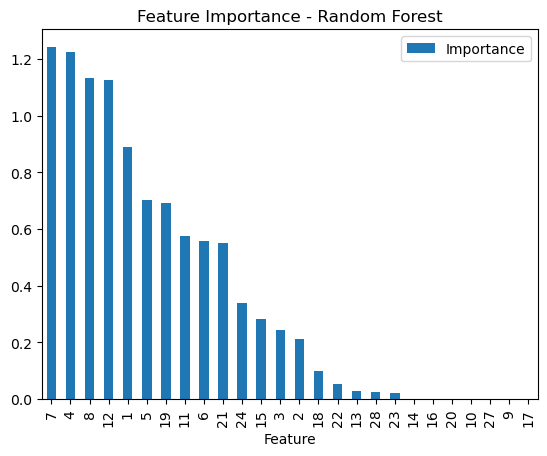

In [35]:
feature_importance_rf = rf_clf.feature_importances_ * 10

features_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance_rf})
features_rf = features_rf.sort_values(by='Importance', ascending=False)

print(features_rf)

features_rf.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance - Random Forest')
plt.show()

## Existence

In [36]:
existence = up_to_act.applymap(lambda x: 1 if x > 1 else x)

In [37]:
X = existence.drop(columns = ['29', 'activated'])
Y = existence['activated'].values.flatten()

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [39]:
rf_clf_existence = RandomForestClassifier(random_state = 42)

In [40]:
rf_clf_existence.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [41]:
y_pred_rf_existence = rf_clf_existence.predict(X_test)
accuracy_rf = accuracy_score(Y_test, y_pred_rf_existence)
precision_rf = precision_score(Y_test, y_pred_rf_existence)
recall_rf = recall_score(Y_test, y_pred_rf_existence)

print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f'Accuracy: {accuracy_rf:.4f}')

Precision: 0.9392
Recall: 0.4912
Accuracy: 0.8703


   Feature  Importance
6        7      2.5661
11      12      2.0532
7        8      1.8703
20      21      0.7912
14      15      0.5021
0        1      0.4664
5        6      0.4309
10      11      0.2138
1        2      0.1972
18      19      0.1964
4        5      0.1651
17      18      0.1477
3        4      0.1343
2        3      0.0947
23      24      0.0522
25      28      0.0468
21      22      0.0356
12      13      0.0189
22      23      0.0107
13      14      0.0028
15      16      0.0022
19      20      0.0010
9       10      0.0005
24      27      0.0001
8        9      0.0000
16      17      0.0000


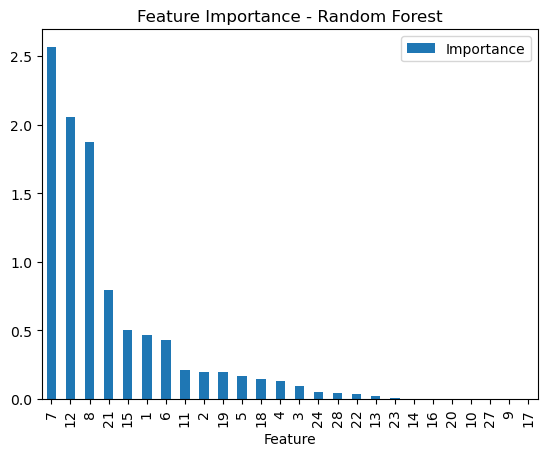

In [42]:
feature_importance_rf = rf_clf_existence.feature_importances_ * 10

features_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance_rf})
features_rf = features_rf.sort_values(by='Importance', ascending=False)

print(features_rf)

features_rf.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance - Random Forest')
plt.show()

# XGBOOST

## Frequency

In [43]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import plot_importance

In [44]:
up_to_act = pd.read_csv('ActivationLogRegdata.csv')

In [45]:
X = up_to_act.drop(columns = ['29', 'activated'])
Y = up_to_act['activated'].values.flatten()

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [47]:
sum_negatives = sum(Y_train == 0)
sum_positives = sum(Y_train == 1)
scale_pos_weight = sum_negatives / sum_positives

In [48]:
xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight = scale_pos_weight)
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [49]:
xgb_pred = xgb.predict(X_test)

accuracy = accuracy_score(Y_test, xgb_pred)
precision = precision_score(Y_test, xgb_pred)
recall = recall_score(Y_test, xgb_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 0.6201548869677597
Recall: 0.7603990348255123
Accuracy: 0.8307494656550118


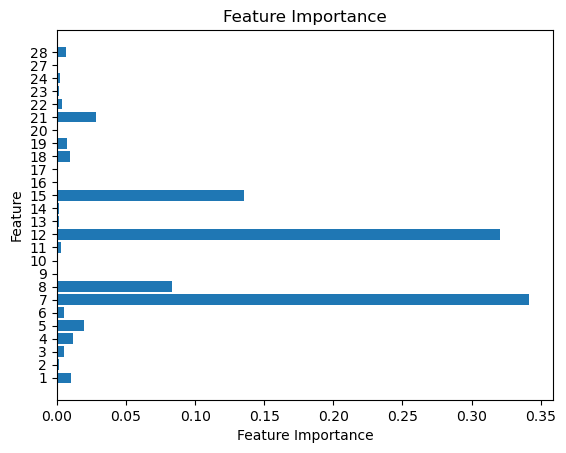

In [50]:
importance = xgb.feature_importances_
feature_names = X_train.columns  # Adjust this if your features are indexed differently

# Create a bar plot
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

## Existence

In [51]:
import xgboost as xgb
from pdpbox import pdp

In [52]:
existence = up_to_act.applymap(lambda x: 1 if x > 1 else x)

In [53]:
X = existence.drop(columns = ['29', 'activated'])
Y = existence['activated'].values.flatten()

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [55]:
sum_negatives = sum(Y_train == 0)
sum_positives = sum(Y_train == 1)
scale_pos_weight = sum_negatives / sum_positives

In [56]:
xgb_existence = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight = scale_pos_weight)
xgb_existence.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [57]:
xgb_exist_pred = xgb_existence.predict(X_test)

accuracy = accuracy_score(Y_test, xgb_exist_pred)
precision = precision_score(Y_test, xgb_exist_pred)
recall = recall_score(Y_test, xgb_exist_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 0.5523352224064727
Recall: 0.7277343609320416
Accuracy: 0.7931379157376841


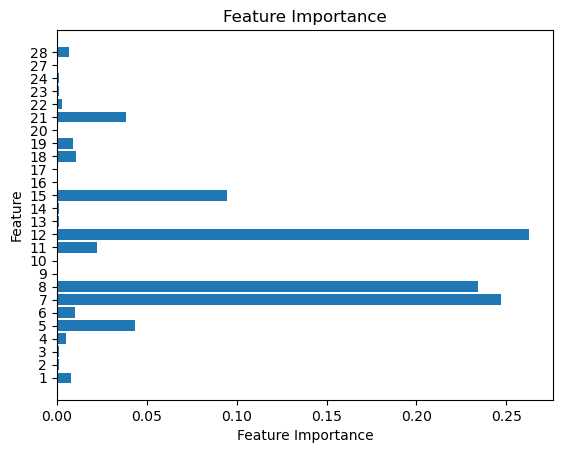

In [58]:
importance = xgb_existence.feature_importances_
feature_names = X_train.columns  # Adjust this if your features are indexed differently

# Create a bar plot
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

## Look at the rows that contain purchase in them and do some analysis on those

In [59]:
def activated(x):
    if 29 in x:
        return 1
    else:
        return 0

In [64]:
up_to_activation = pd.read_csv('up_to_activation.csv')

In [65]:
grouped_lists = up_to_activation.groupby('new_session')['ed_id'].apply(list).reset_index()

In [66]:
grouped_lists['activated'] = grouped_lists['ed_id'].apply(activated)

In [67]:
purchased_group = grouped_lists[up_to_act['7'] == 1]

In [68]:
percent_activated = round(sum(purchased_group['activated'] == 1)/len(purchased_group['activated']), 3) * 100

In [69]:
print(percent_activated,'% of those who made a purchase ended up activating')

95.7 % of those who made a purchase ended up activating


In [70]:
purchased_group['ed_id']

13         [2, 6, 19, 3, 19, 19, 19, 3, 19, 19, 19, 19, 1...
36         [19, 19, 19, 19, 19, 3, 19, 19, 19, 3, 19, 3, ...
44         [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...
46         [2, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 3,...
47         [19, 19, 19, 3, 19, 19, 19, 3, 19, 19, 19, 19,...
                                 ...                        
1735601    [21, 12, 4, 11, 5, 6, 5, 5, 5, 4, 4, 4, 11, 4,...
1735712    [21, 12, 1, 4, 4, 4, 4, 4, 4, 4, 6, 11, 11, 11...
1735721    [21, 12, 1, 3, 3, 3, 19, 19, 19, 19, 19, 19, 1...
1735729    [21, 2, 12, 19, 19, 19, 19, 19, 19, 19, 19, 19...
1735766    [2, 19, 19, 19, 19, 3, 12, 19, 4, 4, 4, 4, 4, ...
Name: ed_id, Length: 124182, dtype: object

In [72]:
purchased_group

,new_session,ed_id,activated
13,14,"[2, 6, 19, 3, 19, 19, 19, 3, 19, 19, 19, 19, 1...",0
36,37,"[19, 19, 19, 19, 19, 3, 19, 19, 19, 3, 19, 3, ...",1
44,45,"[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...",1
46,47,"[2, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 3,...",1
47,48,"[19, 19, 19, 3, 19, 19, 19, 3, 19, 19, 19, 19,...",1
...,...,...,...
1735601,1735602,"[21, 12, 4, 11, 5, 6, 5, 5, 5, 4, 4, 4, 11, 4,...",1
1735712,1735713,"[21, 12, 1, 4, 4, 4, 4, 4, 4, 4, 6, 11, 11, 11...",1
1735721,1735722,"[21, 12, 1, 3, 3, 3, 19, 19, 19, 19, 19, 19, 1...",0
1735729,1735730,"[21, 2, 12, 19, 19, 19, 19, 19, 19, 19, 19, 19...",1


## How many activated accounts have a purchase?

In [92]:
activated_lists = grouped_lists[grouped_lists['activated'] == 1]

In [100]:
len(activated_lists)

416441

In [93]:
activated_purchased_group = activated_lists[up_to_act['7'] == 1]

In [103]:
len(activated_purchased_group)

118870

In [106]:
activated_percent_purchased = round(((len(activated_purchased_group)/len(activated_lists)) * 100), 3)

In [108]:
print(activated_percent_purchased,'% of those who are activated already made a purchase')

28.544 % of those who are activated already made a purchase


### Markov Chain of Activated Accounts

In [73]:
import seaborn as sns

In [74]:
sessions_with_29 = up_to_activation[up_to_activation['ed_id'] == 29]['new_session'].unique()

# Keep only the rows in 'up_to_activation' where 'new_session' is in 'sessions_with_29'
up_to_activation_filtered = up_to_activation[up_to_activation['new_session'].isin(sessions_with_29)]

In [75]:
up_to_activation_filtered

,customer_id,account_id,ed_id,event_name,event_timestamp,journey_steps_until_end,new_session
350,-1257367741,1076891306,19,application_web_view,2023-01-04T17:41:54.000Z,1,12
351,-1257367741,1076891306,19,application_web_view,2023-01-04T17:41:56.000Z,2,12
352,-1257367741,1076891306,19,application_web_view,2023-01-04T17:41:57.000Z,3,12
353,-1257367741,1076891306,19,application_web_view,2023-01-04T17:43:00.000Z,4,12
354,-1257367741,1076891306,19,application_web_view,2023-01-04T17:43:00.000Z,5,12
...,...,...,...,...,...,...,...
56585945,-865005459,-983311387,5,view_cart,2021-05-13T21:33:23.000Z,36,1735767
56585946,-865005459,-983311387,6,begin_checkout,2021-05-13T21:34:09.000Z,37,1735767
56585947,-865005459,-983311387,8,place_downpayment,2021-05-13T21:40:05.000Z,38,1735767
56585948,-865005459,-983311387,7,place_order_web,2021-05-13T21:40:05.000Z,39,1735767


In [76]:
sessions = up_to_activation_filtered.groupby('new_session')['event_name'].apply(list)

In [175]:
from collections import defaultdict

transition_counts = defaultdict(lambda: defaultdict(int))

In [176]:
for sequence in sessions:
    for i in range(len(sequence) - 1):
        current, next = sequence[i], sequence[i + 1]
        transition_counts[current][next] += 1

In [177]:
transition_matrix = defaultdict(lambda: defaultdict(float))

for current, next_states in transition_counts.items():
    total = sum(next_states.values())
    for next_state, count in next_states.items():
        transition_matrix[current][next_state] = count / total

In [178]:
transition_df = pd.DataFrame(transition_matrix).fillna(0).T

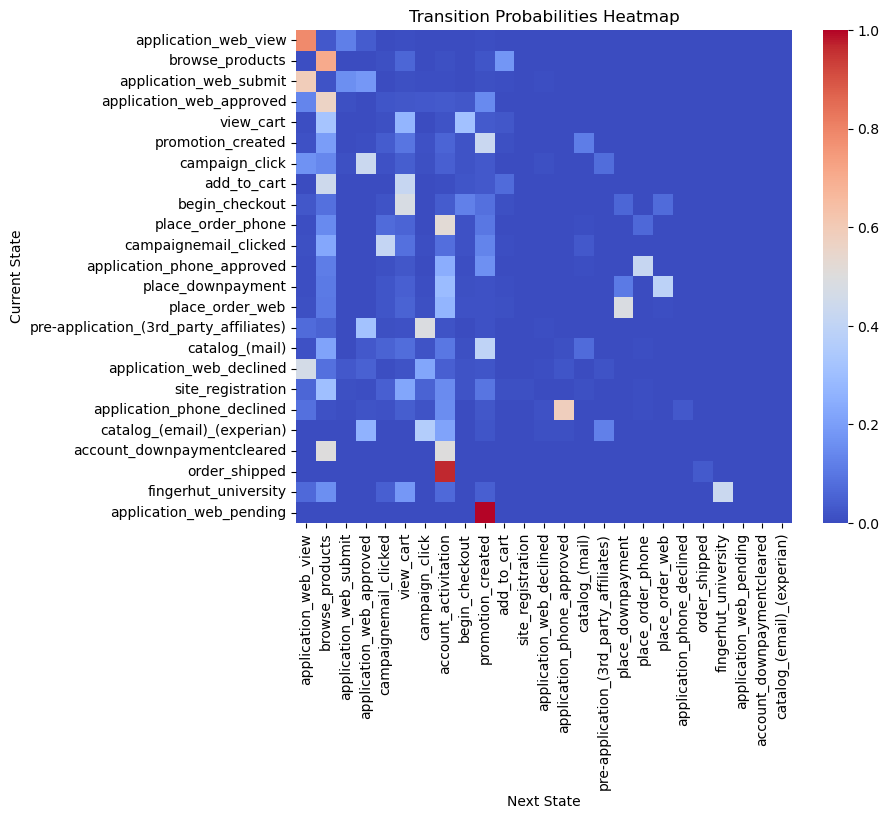

In [180]:
plt.figure(figsize=(8, 6.4))  # Adjust the figure size as necessary
sns.heatmap(transition_df, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Transition Probabilities Heatmap')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.show()

### Markov Chain of Un Activated Accounts

In [110]:
up_to_activation_unactivated = up_to_activation[~up_to_activation['new_session'].isin(sessions_with_29)]

In [111]:
sessions_unactivated = up_to_activation_unactivated.groupby('new_session')['event_name'].apply(list)

In [112]:
from collections import defaultdict

transition_counts = defaultdict(lambda: defaultdict(int))

In [113]:
for sequence in sessions_unactivated:
    for i in range(len(sequence) - 1):
        current, next = sequence[i], sequence[i + 1]
        transition_counts[current][next] += 1

In [114]:
transition_matrix = defaultdict(lambda: defaultdict(float))

for current, next_states in transition_counts.items():
    total = sum(next_states.values())
    for next_state, count in next_states.items():
        transition_matrix[current][next_state] = count / total

In [115]:
transition_df = pd.DataFrame(transition_matrix).fillna(0).T

In [116]:
transition_df.loc['application_phone_pending'] = 0

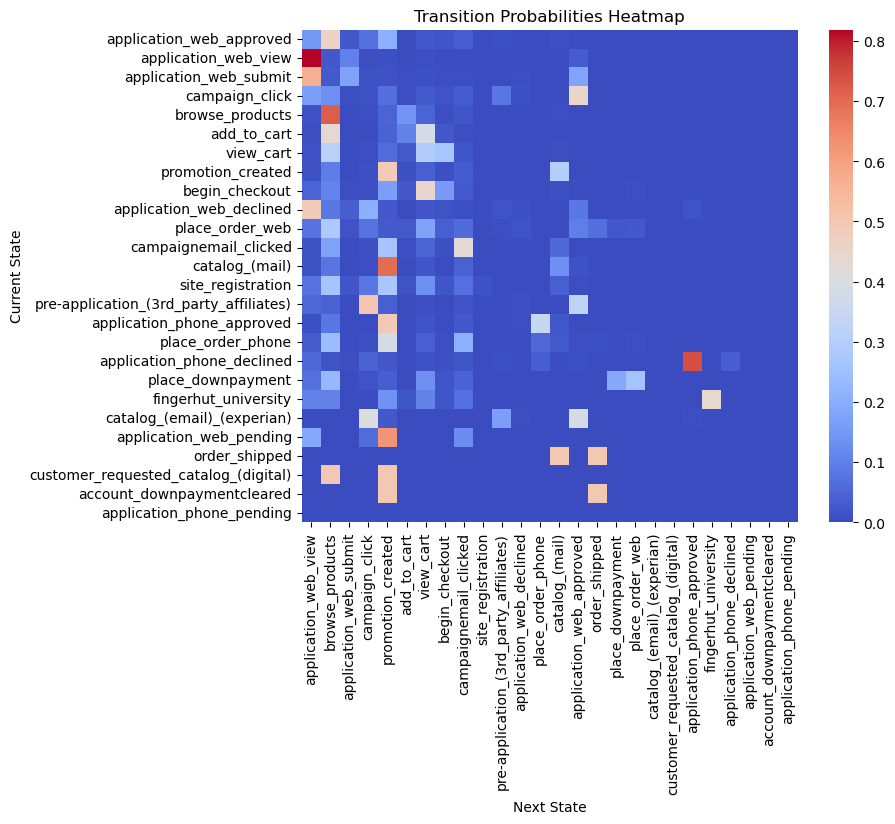

In [117]:
plt.figure(figsize=(8, 6.4))  # Adjust the figure size as necessary
sns.heatmap(transition_df, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Transition Probabilities Heatmap')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.show()

## Look at last 5 events in unactivated sessions

In [159]:
sessions_unactivated = up_to_activation_unactivated.groupby('new_session')['event_name'].apply(list)

In [160]:
last_five_elements = sessions_unactivated.apply(lambda x: x[-5:])

In [151]:
flattened_elements = [element for sublist in last_five_elements for element in sublist]
element_freq = pd.Series(flattened_elements).value_counts()

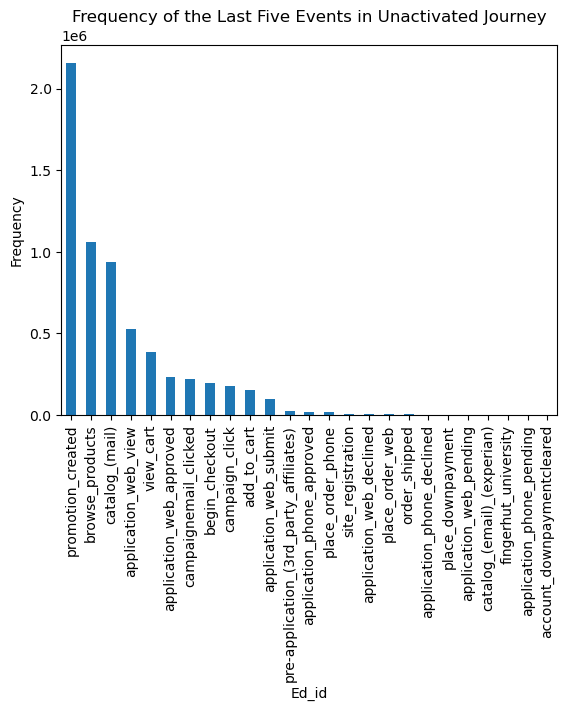

In [152]:
element_freq.plot(kind='bar')
plt.title('Frequency of the Last Five Events in Unactivated Journey')
plt.xlabel('Ed_id')
plt.ylabel('Frequency')
plt.show()

## Look at last 5 elements in activated journeys

In [169]:
sessions_with_29 = up_to_activation[up_to_activation['ed_id'] == 29]['new_session'].unique()

In [170]:
up_to_activation_filtered = up_to_activation[up_to_activation['new_session'].isin(sessions_with_29)]

In [182]:
sessions = up_to_activation_filtered.groupby('new_session')['event_name'].apply(list)

In [183]:
last_five_elements = sessions.apply(lambda x: x[-5:])

In [184]:
flattened_elements = [element for sublist in last_five_elements for element in sublist]
element_freq = pd.Series(flattened_elements).value_counts()

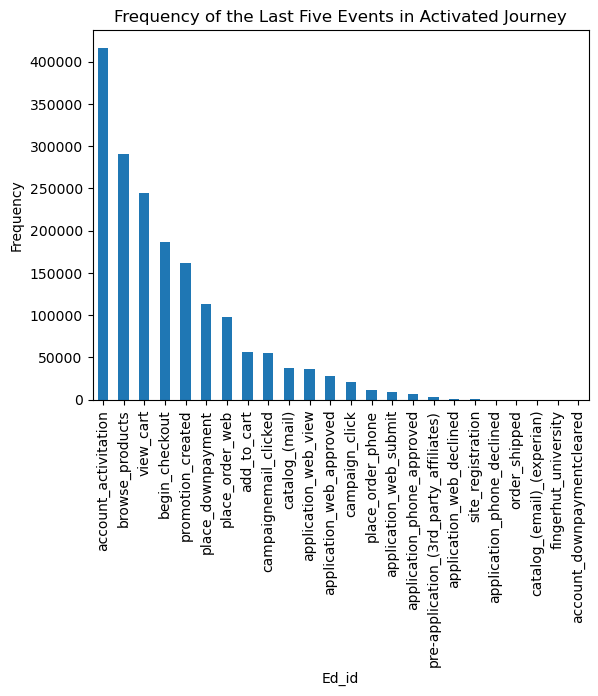

In [185]:
element_freq.plot(kind='bar')
plt.title('Frequency of the Last Five Events in Activated Journey')
plt.xlabel('Ed_id')
plt.ylabel('Frequency')
plt.show()